Easton Potokar

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import mne                               #package to handle EEG data files
import os, seaborn, re
from scipy import io                     #for loading matlab file

plt.style.use("seaborn")
plt.rcParams["figure.dpi"] = 300

fs = 256                                 #sample size

In [2]:
def read_data(filename):
    return pd.read_pickle(filename)

def plot_signal(data, channels=None, slices=None):
    #read in data if it's a string
    if isinstance(data, str):
        data = read_data(data)
        
    #get all channels needed
    if channels == None:
        channels = sorted(list(data.columns))
        channels.remove("ECG EKG")
        
    #get indices of data
    if slices == None:
        low = 0
        up = len(data.index)
    elif slices is tuple or slices is list:
        low = slices[0]*fs
        up = slices[1]*fs
    else:
        length = fs*slices
        low = np.random.randint(slices, len(data.index)-slices)
        up = low + length
        
    #plot them
    n = int(np.ceil( len(channels) / 2))
    fig, ax = plt.subplots(n, 2, sharex=True, sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.01})
    ax = ax.reshape(-1)
    fig.set_size_inches(20, 2*n, forward=True)
    for i, chan in enumerate(channels):
        ax[i].plot(data.index[low:up], data[chan].iloc[low:up])  
        ax[i].set_title(chan)
    # Set common labels
    fig.text(0.5, 0.01*n, 'Time (sec)', ha='center', va='center')
    fig.text(0.08, 0.5, 'mV', ha='center', va='center', rotation='vertical')

# Introduction

Neonatal seizures are a common occurrence and require immediate care. Detection is only possible through continuous electroencephalogram (EEG) monitoring. Unfortunately, this places a heavy burden on NICUs (Newborn Intensive Care Units) due to the expertise needed to interpret EEGs that is generally not available in a NICU. Alternative options include a simplified easy-to-read trend of the EEG output known as an amplitude integrated EEG (aEEG). While it has its strengths, drawbacks include short duration and low amplitude of seizures, causing them to be missed entirely. 

Continuous multichannel EEG is the gold standard for detecting seizures but expert interpretation is not readily available to NICUs. Alternatives include providing experts remote access to the EEG, but this still requires 24 hour surveillance, also a heavy load.

The dataset that will be used is available through a public repository containing EEG recordings of 79 term neonates admitted to the NICU, with an meidan duration of 74 minutes available at https://zenodo.org/record/2547147. Each EEG recording includes 21 channels of data, each recorded at 256Hz, thus containing frequencies up to 128HZ. These recordings were examined by three experts with their labelings of either a seizure being present or not being present included at second intervals. Along with each of these neonates is included clinical information about them including body weight in grams, gestational age, and postmenstrual age. 

Questions looking to be answered by this dataset include, but are not limited to: Is there a correlation between BW/GA and frequency of seizures? Is it more prevental in males or females? Are there certain frequencies in the EEG data where seizures occur? Do certain channels in the EEG recordings correlate more with seizures than others? These are slightly shifted from those presented in my proposal, but the rest of the proposal still remains intact. 

# Data Preparation
## Data Scraping

The data can be found at https://zenodo.org/record/2547147, and is best downloaded using the pip package `zenodo-get`. Running `pip install zenodo-get` followed by `zenodo_get.py 10.5281/zenodo.2547147` downloads all data and checks the md5sums to ensure everything downloaded properly. Since this process was simple enough, no additional scraping methods were needed.

## Data Cleaning

### Cleaning Clinical Information

The data is stored in a mixture of `.csv`, `.mat`, and `.edf` files. The `.edf` files are the standard for EEG data and can be read using the python package `mne`. First, we load the `.csv` files into a pandas dataframe and clean the data found in them. We load the location of the corresponding EEG file, the ID of the infant (index from 1 to 79), the gender, gestional age (GA) in weeks, the post menstrual age (PMA) at time of EEG recording in weeks, and the body weight (BW) in grams. GA refers to week when born since conception, and PMA is current week since conception. 

In addition, 22 of the neonates don't have any expert reviews, so we drop those rows, bringing the total to 57. We replace both the strings in BW, GA, and PMA with floats at the center of their intervals. Since the intervals hold value with respect to each other (ie one interval is definitely larger than another), it is hoped this will aid in analysis. Further any N/A features are replaced with the mean of other infants containing other similar features. The expert analysis is also loaded in from the `.mat` file and saved as a column in the pandas dataframe.

In [30]:
#load in clinical data
ci = pd.read_csv("data-og/clinical_information.csv", index_col="ID", usecols=["EEG file", "ID", "Gender", "GA (weeks)", "BW (g)", "EEG to PMA (weeks)", "Number of Reviewers Annotating Seizure"])

#drop rows without expert annotations
ci = ci[ ci["Number of Reviewers Annotating Seizure"] != 0]

#replace weight string values with middle of interval
replaceBW = {"less than 2500g": 2250,
              "2500 to 3000g": 2750,
              "3000 to 3500g": 3250,
              "3500 to 4000g": 3750,
              "greater than 4000g": 4250,
              }
ci.replace(replaceBW, inplace=True)

#replace GA/PMA string values with middle of interval
def interval(weeks):
    if not isinstance(weeks, str) and np.isnan(weeks):
        return weeks
    values = re.compile(r"(\d{2})").findall(weeks)
    return (float(values[0]) + float(values[1])) / 2
ci['GA (weeks)'] = ci['GA (weeks)'].apply(interval)
ci['EEG to PMA (weeks)'] = ci['EEG to PMA (weeks)'].apply(interval)

#replace NaN values with something useful
#Both in the GA column
missing_idx = pd.isna(ci["GA (weeks)"])
for index, row in ci.loc[missing_idx].iterrows():
    similar = ci['EEG to PMA (weeks)'] == ci.loc[index, 'EEG to PMA (weeks)']
    ci.loc[index, 'GA (weeks)'] = ci.loc[similar, 'GA (weeks)'].mean()    
#and in the BW column
missing_idx = pd.isna(ci["BW (g)"])
for index, row in ci.loc[missing_idx].iterrows():
    similar = ci['GA (weeks)'] == ci.loc[index, 'GA (weeks)']
    ci.loc[index, 'BW (g)'] = ci.loc[similar, 'BW (g)'].mean() 
#there is a single missing m/f. Replace with the mode
missing_idx = pd.isna(ci["Gender"])
for index, row in ci.loc[missing_idx].iterrows():
    ci.loc[index, 'Gender'] = ci['Gender'].mode()[0]

#load in all experts analysis from .mat file. Note we save as a numpy array b/c each child has a different length of recording
annot = io.loadmat('data-og/annotations_2017.mat')['annotat_new']
ci['expertA'] = [annot[0,i-1][0,:] for i in ci.index]
ci['expertB'] = [annot[0,i-1][1,:] for i in ci.index]
ci['expertC'] = [annot[0,i-1][2,:] for i in ci.index]

#visualize a couple of rows to see how it looks
ci.sample(5)

,EEG file,Gender,BW (g),GA (weeks),EEG to PMA (weeks),Number of Reviewers Annotating Seizure,expertA,expertB,expertC
ID,,,,,,,,,
13,eeg13,m,3750.000000,38.5,39.5,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
20,eeg20,m,2750.000000,38.5,38.5,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
71,eeg71,m,2250.000000,36.5,39.5,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
52,eeg52,m,2583.333333,35.5,43.5,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
74,eeg74,m,2750.000000,34.5,35.5,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Cleaning EEG Data

Next, we use `mne` to read all data into a pandas DataFrame. The corresponding info, like the BW; GA; PMA; etc, is saved as metadata on each seperate dataFrame and then saved as a pickle file for later analysis, since each file is too large to be opened simultaneously. Further we check to ensure that the experts' analyses length correctly matches the EEG recordings, and we relabel the EEG recording's channels to all match. 

In [31]:
#iterate through all of files
for i in ci.index:
    #read in all of the raw data
    raw = mne.io.read_raw_edf("data-og/{}.edf".format(ci["EEG file"][i]))
    channels = raw.ch_names
    signals = raw[channels][0]
    time = raw[0,:][1]

    #clean channel names
    for k, chan in enumerate(channels):
        #if it contains -REF at end
        try:
            channels[k] = re.compile(r"\s(\w*?)-").findall(chan)[0]
        #otherwise take first word
        except:
            channels[k] = re.compile(r"\s(\w.*)").findall(chan)[0]
        #relabel to things I like better
        if channels[k] == "Effort":
            channels[k] = "Resp Effort"
        if channels[k] == "EKG":
            channels[k] = "ECG EKG"
    
    #check to make sure there's no duplicate channels
    if len(set(channels)) != len(channels):
        raise ValueError("Channel has non unique data")
    #check to make sure has the same channels as the previous one
    if i == 1:
        chan_prev = channels
    else:
        if set(channels) != set(chan_prev):
            raise ValueError("EEGs have different channels")
        chan_prev = channels
    
    #save into pandas DataFrame
    df = pd.DataFrame(signals.T, columns=channels, index=time)
    df.ID = i
    df.gender = ci['Gender'][i]
    df.bw = ci['BW (g)'][i]
    df.ga = ci['GA (weeks)'][i]
    df._metadata = ['gender', 'bw', 'ga', 'ID']
    
    #check to make sure all experts analyzed correctly sized data
    if len(ci['expertA'][i]) != len(df.index) / 256:
        print(len(ci['expertA'][i]), len(df.index) / 256)
        raise ValueError("EEG {} has mismatched expert A and time stamps")
    if len(ci['expertB'][i]) != len(df.index) / 256:
        print(len(ci['expertB'][i]), len(df.index) / 256)
        raise ValueError("EEG {} has mismatched expert B and time stamps")
    if len(ci['expertC'][i]) != len(df.index) / 256:
        print(len(ci['expertC'][i]), len(df.index) / 256)
        raise ValueError("EEG {} has mismatched expert C and time stamps")
        
    #save to pickle file and update location in ci
    print("Saving {} to pkl...".format(ci["EEG file"][i]))
    df.to_pickle('data/{}.pkl'.format(ci["EEG file"][i]), protocol=-1)
    ci.loc[i, "EEG file"] = "data/{}.pkl".format(ci.loc[i, "EEG file"])
    
ci.to_pickle('data/ci_cleaned.pkl', protocol=-1)

Extracting EDF parameters from /home/contagon6/Documents/nicu-eeg-dataproject/data-og/eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Saving eeg1 to pkl...
Extracting EDF parameters from /home/contagon6/Documents/nicu-eeg-dataproject/data-og/eeg2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Saving eeg2 to pkl...
Extracting EDF parameters from /home/contagon6/Documents/nicu-eeg-dataproject/data-og/eeg4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Saving eeg4 to pkl...
Extracting EDF parameters from /home/contagon6/Documents/nicu-eeg-dataproject/data-og/eeg5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Saving eeg5 to pkl...
Extracting EDF parameters from /home/contagon6/Documents/nicu-eeg-dataproject/data-og/eeg6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Saving 

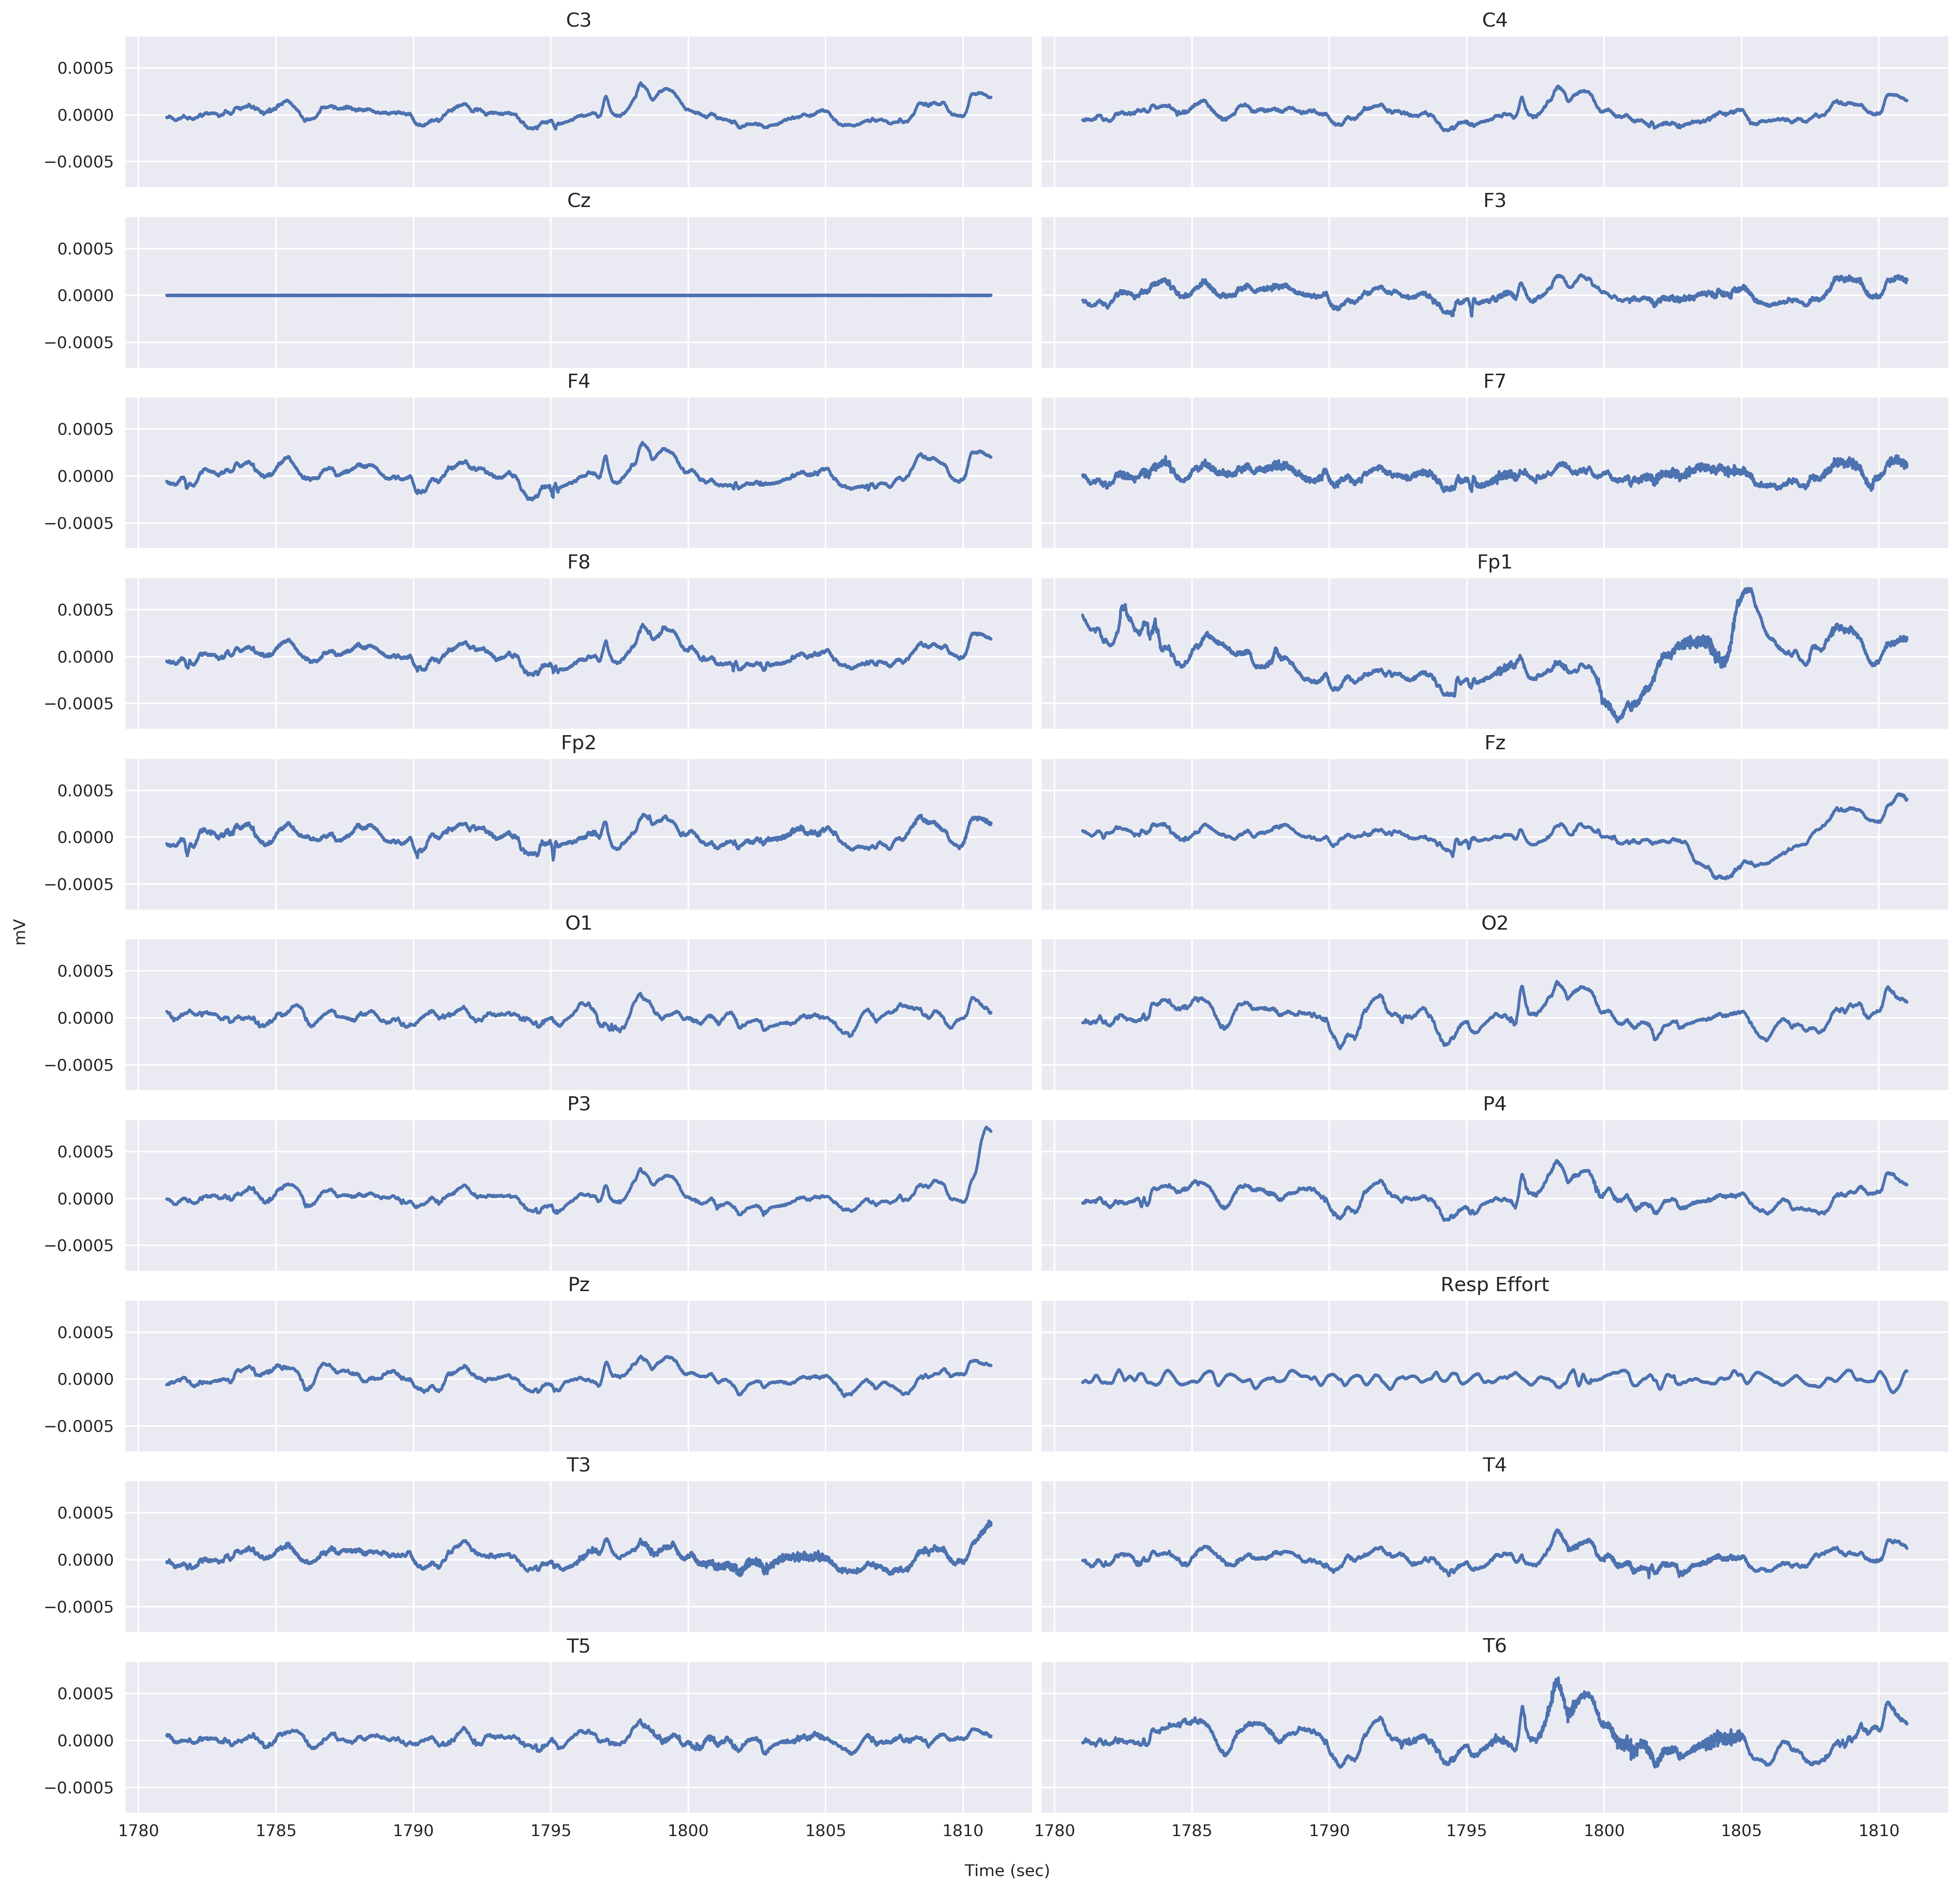

In [119]:
# we plot a random sample of 30 seconds from a random neonate
plot_signal(ci.loc[np.random.randint(1,79), 'EEG file'], channels=None, slices=30)

## Potential Data Problems

I believe the source of the data to be quite reliable. The data was recorded from a hospital in Finland by a third party, which removes any sort of bias or data picking. The group who posted it was also looking to implement different ML algorithmns to detect seizures and appeared to be at least moderately successful using an SVM. As long as the group didn't cherry-pick data for their model, which seems unlikely since that would be unethical and it's been published, the data should be sufficiently reliable.

Upon examining the data, I found that the length of recordings didn't match up with the length of some of the analyses by "Expert A", which obviously raises a lot of alarms. Upon further inspection, there appears to be something wrong with the `.csv` file containing Expert A's annotations. Fortunately, a `.mat` file was also included in the dataset and all the lengths match up for each expert and the EEG data. Beyond that, all clinical data appears to have valid information. While examining some of the EEG recordings, it appears that some channels are occaisonally mostly noise as well, but I could be mistaken. Further analysis will be done in the frequency domain during Feature Engineering.

# Feature Engineering

### Clinical Information

First we add features to the clinical data. We add average seizures for each expert, and total average as well (had to check how many experts annotated it). We also one hot encode the gender column.

In [36]:
#columns for length of recording
ci = read_data('data/ci_cleaned.pkl')
ci['minutes'] = [len(ci['expertA'][i])/60 for i in ci.index]

#make rows of expert analysis
ci['expertA_avg'] = [np.sum(ci['expertA'][i]) / len(ci['expertA'][i]) for i in ci.index]
ci['expertB_avg'] = [np.sum(ci['expertB'][i]) / len(ci['expertB'][i]) for i in ci.index]
ci['expertC_avg'] = [np.sum(ci['expertC'][i]) / len(ci['expertC'][i]) for i in ci.index]


ci['expert_avg'] = (ci['expertA_avg'] + ci['expertB_avg'] + ci['expertC_avg']) / 3

#create hot encoded gender column
ci['Male'] = ( ci['Gender'] == "m" ).apply(int)

### EEG Recordings

We set up a way to take the Fourier Transform of any portion of any channel quickly and easily

In [ ]:
def fft(data):
    